## Regional Satellite / WRF-Chem plotting script (mapping to new grid)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib import ticker
from matplotlib import interactive
interactive(True)

import xarray as xr
import numpy as np
import pandas as pd

from scipy import stats
from scipy.interpolate import griddata
import cartopy.crs as ccrs



In [2]:
# loads column and lat/lon data, and converts to panda array.
#    This includes copying the time index to our model data, because
#    I had not added this to the model netcdf files when creating them.
def load_create_dataframe(sat_datadask,model_datadask):

    sat_col_data = sat_datadask.column.copy(deep=True)
    sat_error_data = sat_datadask.error.copy(deep=True)
    sat_vprof_data = sat_datadask.VertProf.copy(deep=True)
    sat_clcov_data = sat_datadask.CLcov.copy(deep=True)
    sat_angle_data = sat_datadask.angle.copy(deep=True)
    lat_data = sat_datadask.latitude.copy(deep=True)
    lon_data = sat_datadask.longitude.copy(deep=True)
    
    # convert from xarray to pandas dataframe
    cold = sat_col_data.to_dataframe()
    errd = sat_error_data.to_dataframe()
    verd = sat_vprof_data.to_dataframe()
    clcd = sat_clcov_data.to_dataframe()
    angd = sat_angle_data.to_dataframe()
    latd = lat_data.to_dataframe()
    lond = lon_data.to_dataframe()
 
    # pull out time from the satellite data
    sat_time_data = satellite_datadask.time.copy(deep=True)
    sat_time = sat_time_data.to_dataframe().reset_index(drop=True)
    
    # load and add time to the model data
    model_data = model_datadask.nh3.copy(deep=True)
    model = model_data.to_dataframe().reset_index(drop=True)
    model_time = pd.concat([sat_time,model],axis=1,sort=False)
    modd = model_time.set_index('time')
    
    result = pd.concat([modd,cold,errd,verd,clcd,angd,latd,lond], axis=1, sort=False)

    return result

In [3]:
# groups column data into defined lat/lon bins, takes mean value for each bin, 
#                                and returns the 2D data array of these means
def grid_satellite_model_data(dataframe,lat_bins,lon_bins,lat_mid,lon_mid):
    
    # drop NaN values, and then group into the lat/long bins
    resn = dataframe.dropna()
    #grs = dataframe.groupby([pd.cut(dataframe.latitude,lat_bins),pd.cut(dataframe.longitude,lon_bins)])
    grs = resn.groupby([pd.cut(resn.latitude,lat_bins),pd.cut(resn.longitude,lon_bins)])
    
    # get mean and count values, and reset the indexes for our dataset 
    #     - the longitude and latitude bins will now be column data rather than indexes
    grmean  = grs.column.mean().reset_index()
    grcount = grs.column.count().reset_index()
    grnh3mean = grs.nh3.mean().reset_index()

    
    # determine the grid centre locations from the grid information for the dataset
    grmean['Mid_Lon'] = grmean['longitude'].apply(lambda x: x.mid)
    grmean['Mid_Lat'] = grmean['latitude'].apply(lambda x: x.mid)
    grnh3mean['Mid_Lon'] = grnh3mean['longitude'].apply(lambda x: x.mid)
    grnh3mean['Mid_Lat'] = grnh3mean['latitude'].apply(lambda x: x.mid)

    # create 2D mesh for storing extracted data 
    lon_grid, lat_grid = np.meshgrid(lon_mid,lat_mid)
    
    # grid the model data (and counts)
    col_grid = griddata((grmean.Mid_Lon,grmean.Mid_Lat),grmean.column,(lon_grid,lat_grid))
    nh3_grid = griddata((grnh3mean.Mid_Lon,grnh3mean.Mid_Lat),grnh3mean.nh3,(lon_grid,lat_grid))
    count_grid = griddata((grmean.Mid_Lon,grmean.Mid_Lat),grcount.column,(lon_grid,lat_grid))
    
    return col_grid, nh3_grid, lon_grid, lat_grid, count_grid


#### Load satellite and model data

The 'time' index in the satellite data is 'UTC time of acquisition', in units 'HHMMSS.ms', so I think that we need to be careful to only load data for a single day at a time for this processing. Otherwise the coordinate system could become confused by duplicate values for each day. This doesn't matter for the global satellite data plots, but for this work we are merging model and satellite data, and so we need to be more careful with indexing.

In [4]:
root_path = '/Users/mbessdl2/Documents/Clearflo_data_analysis/'
satellite_file_path = root_path+'satellite_data/'
model_file_path = root_path+'model_column_data/'
date_string = '20120819_*'
satellite_datadask = xr.open_mfdataset(satellite_file_path+'nh3nn_v2_2_'+date_string+'.nc')
model_datadask = xr.open_mfdataset(model_file_path+'Ammonia_Column_'+date_string+'_gasphase_chemistry.nc')

In [5]:
work_data = load_create_dataframe(satellite_datadask,model_datadask)

/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [6]:
test_data = work_data.dropna()
test_data

,nh3,column,error,VertProf,CLcov,angle,latitude,longitude
time,,,,,,,,
83649.226562,1.014425e+14,-5.074825e+15,111.548561,1,0.000000,56.669998,62.005711,10.518320
83657.015625,1.127485e+14,7.605215e+14,702.157532,1,0.000000,53.820000,61.507561,12.043880
83657.234375,2.143552e+14,-3.338420e+15,118.360497,1,0.000000,58.400002,61.565578,9.423770
83657.234375,1.057768e+14,-1.563363e+14,2964.528809,1,0.000000,56.669998,61.542728,10.458130
83657.234375,8.725202e+13,-3.592911e+15,129.769394,1,0.000000,56.680000,61.804379,10.490630
83704.796875,7.916770e+13,-1.603944e+16,95.670563,1,19.670000,47.869999,60.918678,14.793950
83705.007812,1.172649e+14,1.403301e+15,293.625580,1,0.000000,53.810001,61.290661,12.008740
83705.007812,1.233074e+14,-3.906285e+15,142.499496,1,0.000000,53.820000,61.044441,11.961510
83705.007812,9.108053e+13,4.093033e+15,177.737793,1,0.000000,52.180000,61.009411,12.793240


### Data regridding

Cleaning:
* I drop any NaN's in the data (both to zoom into the model domain, as work_data.nh3 will be NaN outside of this, and to get rid of the missing values in the satellite data, where work_data.column is a NaN). 


Mapping:
* Both model and satellite data will be mapped onto a fixed lat/lon grid, of resolution 0.5 degrees.


In [7]:
# create the edge values for our lat/lon bins
lat_bins = np.arange(44,60,0.5)
lon_bins = np.arange(-20,15,0.5)
lat_mid = np.arange(44.25,60.25,0.5)
lon_mid = np.arange(-20.25,15.25,0.5)


sat_grid, mod_grid, lon_grid, lat_grid, test_count = grid_satellite_model_data(work_data,lat_bins,lon_bins,lat_mid,lon_mid)


In [24]:
lon_bins

array([-20. , -19.5, -19. , -18.5, -18. , -17.5, -17. , -16.5, -16. ,
       -15.5, -15. , -14.5, -14. , -13.5, -13. , -12.5, -12. , -11.5,
       -11. , -10.5, -10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,  -7. ,
        -6.5,  -6. ,  -5.5,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,  -2.5,
        -2. ,  -1.5,  -1. ,  -0.5,   0. ,   0.5,   1. ,   1.5,   2. ,
         2.5,   3. ,   3.5,   4. ,   4.5,   5. ,   5.5,   6. ,   6.5,
         7. ,   7.5,   8. ,   8.5,   9. ,   9.5,  10. ,  10.5,  11. ,
        11.5,  12. ,  12.5,  13. ,  13.5,  14. ,  14.5])

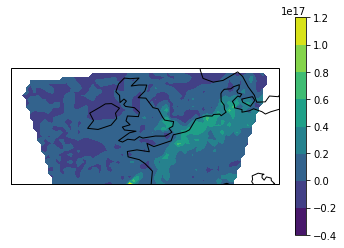

In [8]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#plt.contourf(lon_grid,lat_grid,test_grid,locator=ticker.LogLocator(),vmin=1e14,vmax=1e17)
#plt.contourf(lon_grid,lat_grid,test_grid,locator=ticker.LogLocator(subs=(1.,2.,5.))
#plt.contourf(lon_grid,lat_grid,sat_grid,locator=ticker.LogLocator())
plt.contourf(lon_grid,lat_grid,sat_grid)
plt.colorbar()

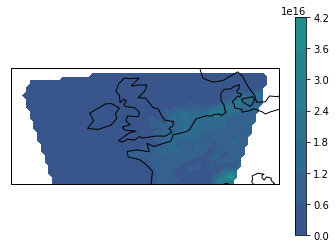

In [21]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#plt.contourf(lon_grid,lat_grid,test_grid,locator=ticker.LogLocator(),vmin=1e14,vmax=1e17)
#plt.contourf(lon_grid,lat_grid,test_grid,locator=ticker.LogLocator(subs=(1.,2.,5.))
#plt.contourf(lon_grid,lat_grid,sat_grid,locator=ticker.LogLocator())
plt.contourf(lon_grid,lat_grid,mod_grid,vmin=-0.4e17,vmax=1.2e17)
#plt.contourf(lon_grid,lat_grid,mod_grid,[-4e16,-2e16,0,2e16,4e16,6e16,8e16,10e16,12e16])
plt.colorbar()

In [16]:
plt.contourf?

In [15]:
seq=[-4e6,-2e6,0,2e6,4e6,6e6,8e6,10e6,12e6]
seq?